In [2]:
import pandas as pd
import os
import requests
import zipfile
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def baixar_extrair(url, zip_path, extract_to):
    try:
        # 1. faz o Download do arquivo
        print(f"Baixando {url} → {zip_path}")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(zip_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print("Download concluído.")

        # 2. Verificando se o arquivo zip é válido
        if not zipfile.is_zipfile(zip_path):
            raise RuntimeError(f"O arquivo baixado não é um ZIP: {zip_path}")

        # 3. Extrair o arquivo para uma pasta
        print(f"Extraindo DF para {extract_to}")
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_to)
        print("Extração concluída.")

    except Exception as e:
        print("Erro durante o processo:", e, file=sys.stderr)
        sys.exit(1)
if __name__ == "__main__":
    # Exemplo de uso:
   # url = "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2025-01.zip"
    url = "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2024-02.zip"
    zip_path = "ca-2025-01.zip"
    extract_to = "preco-gasolina"

    os.makedirs(extract_to, exist_ok=True)
    baixar_extrair(url, zip_path, extract_to)



Baixando https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2024-02.zip → ca-2025-01.zip
Download concluído.
Extraindo para preco-gazolina
Extração concluída.


In [3]:
try:
    df = pd.read_csv('preco-gasolina/Preços semestrais - AUTOMOTIVOS_2025.01.csv',
                     sep=';', 
                     encoding='utf-8',
                     low_memory=False)
    print("Arquivo lido com sucesso!")
    print(df.columns.tolist())
except Exception as e:
    print(f"Erro ao ler o arquivo: {e}")

Arquivo lido com sucesso!
['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda', 'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro', 'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra', 'Unidade de Medida', 'Bandeira']


In [6]:
df[['Regiao - Sigla', 'Estado - Sigla','Produto', 'Data da Coleta', 'Valor de Venda', 'Bandeira']].head(10)


,Regiao - Sigla,Estado - Sigla,Produto,Data da Coleta,Valor de Venda,Bandeira
0,NE,CE,GASOLINA,01/01/2025,6.29,RAIZEN
1,NE,CE,GASOLINA ADITIVADA,01/01/2025,6.49,RAIZEN
2,NE,CE,DIESEL S10,01/01/2025,6.19,RAIZEN
3,NE,CE,ETANOL,01/01/2025,5.19,RAIZEN
4,NE,CE,GASOLINA,01/01/2025,6.53,RAIZEN
5,NE,CE,GASOLINA ADITIVADA,01/01/2025,6.83,RAIZEN
6,NE,CE,DIESEL S10,01/01/2025,6.38,RAIZEN
7,NE,CE,ETANOL,01/01/2025,5.29,RAIZEN
8,NE,CE,GASOLINA,01/01/2025,6.69,VIBRA
9,NE,CE,GASOLINA ADITIVADA,01/01/2025,6.79,VIBRA


In [5]:

# 1) Limpeza + Conversão “em uma linha encadeada”
df['Valor de Venda'] = pd.to_numeric(
    df['Valor de Venda']
      .astype(str)
      .str.replace(r'R\$', '', regex=True)  # Remove o símbolo de R$
      .str.replace(r'\.', '', regex=True)  # Remove o ponto separador de milhar
      .str.replace(',', '.', regex=True),  # Substitui a vírgula por ponto
    errors='coerce'
)

# 2) Verificar resultado
print("Tipo após conversão:", df['Valor de Venda'].dtype)
print("Quantidade de NaNs após conversão:", df['Valor de Venda'].isnull().sum())
print(df['Valor de Venda'].head(6))

Tipo após conversão: float64
Quantidade de NaNs após conversão: 0
0    6.29
1    6.49
2    6.19
3    5.19
4    6.53
5    6.83
Name: Valor de Venda, dtype: float64


In [7]:
# 2) Remover linhas cuja 'Valor de Venda' é NaN ou data inválida
df_plot = df.dropna(subset=['Valor de Venda', 'Data da Coleta']).copy()

# 3) Estatísticas gerais
media_total = df_plot['Valor de Venda'].mean()
mediana_total = df_plot['Valor de Venda'].median()
print(f"Média total: {media_total:.2f}")
print(f"Mediana total: {mediana_total:.2f}")


Média total: 5.89
Mediana total: 6.17


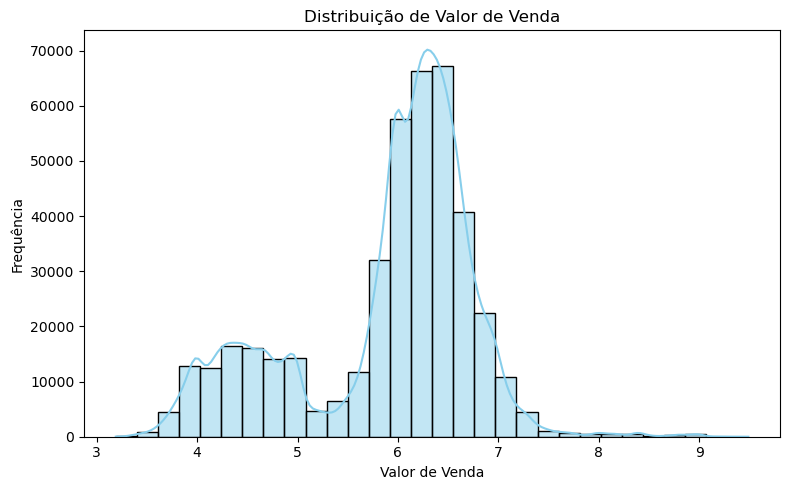

In [8]:
# 4) Distribuição — histograma + KDE
plt.figure(figsize=(8, 5))
sns.histplot(df_plot['Valor de Venda'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição de Valor de Venda')
plt.xlabel('Valor de Venda')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

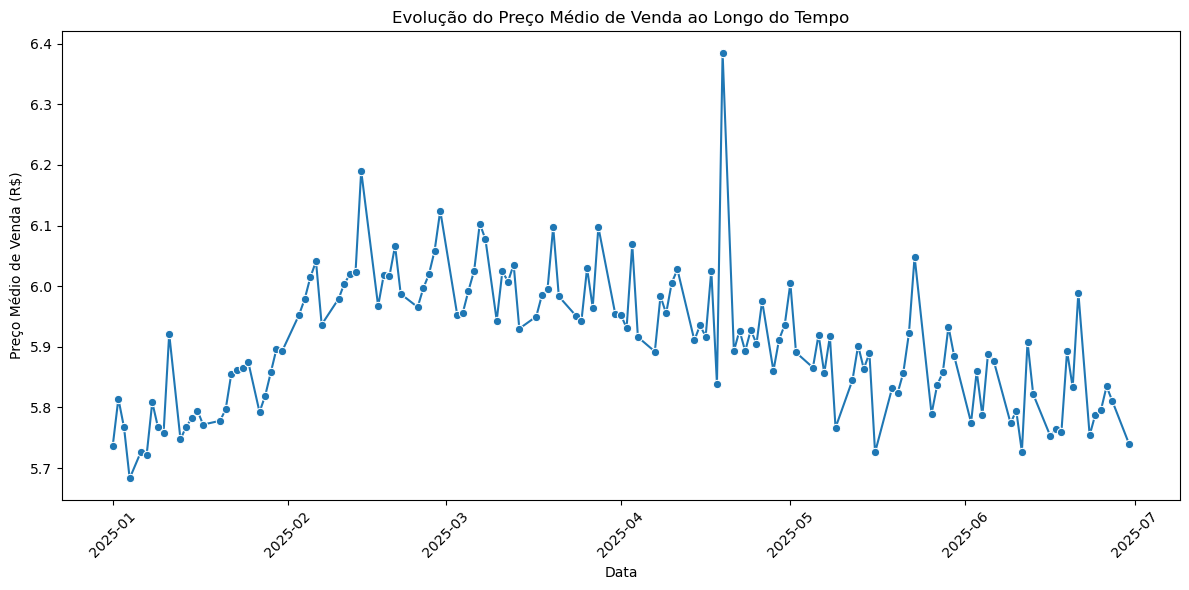

In [9]:
# Convertendo a coluna 'Data da Coleta' para datetime
df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'], format='%d/%m/%Y')

# Calculando o preço médio por data
df_media_data = df.groupby('Data da Coleta')['Valor de Venda'].mean().reset_index()

# Plotando o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_media_data, x='Data da Coleta', y='Valor de Venda', marker='o')
plt.title('Evolução do Preço Médio de Venda ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço Médio de Venda (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

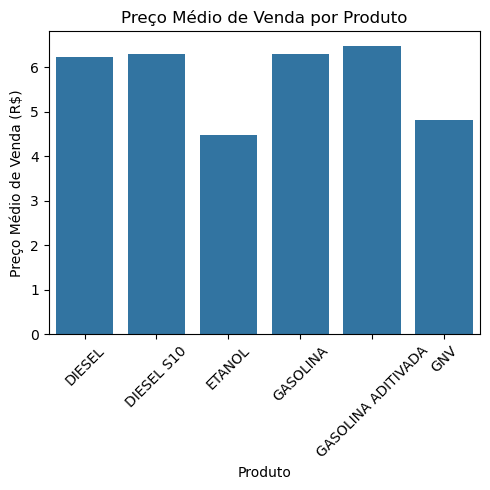

In [15]:
# Calculando o preço médio por produto
df_media_produto = df.groupby('Produto')['Valor de Venda'].mean().reset_index()

# Plotando o gráfico
plt.figure(figsize=(5, 5))
sns.barplot(data=df_media_produto, x='Produto', y='Valor de Venda')
plt.title('Preço Médio de Venda por Produto')
plt.xlabel('Produto')
plt.ylabel('Preço Médio de Venda (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


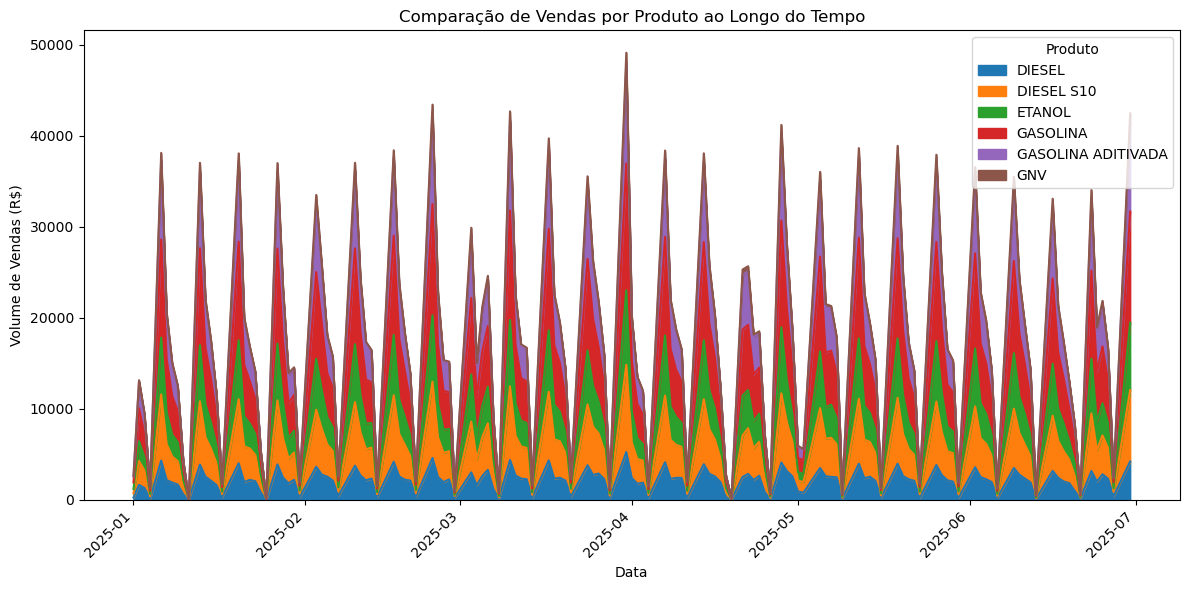

In [23]:
# Plotando o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor: Correlação entre Variáveis')
plt.tight_layout()
plt.show()

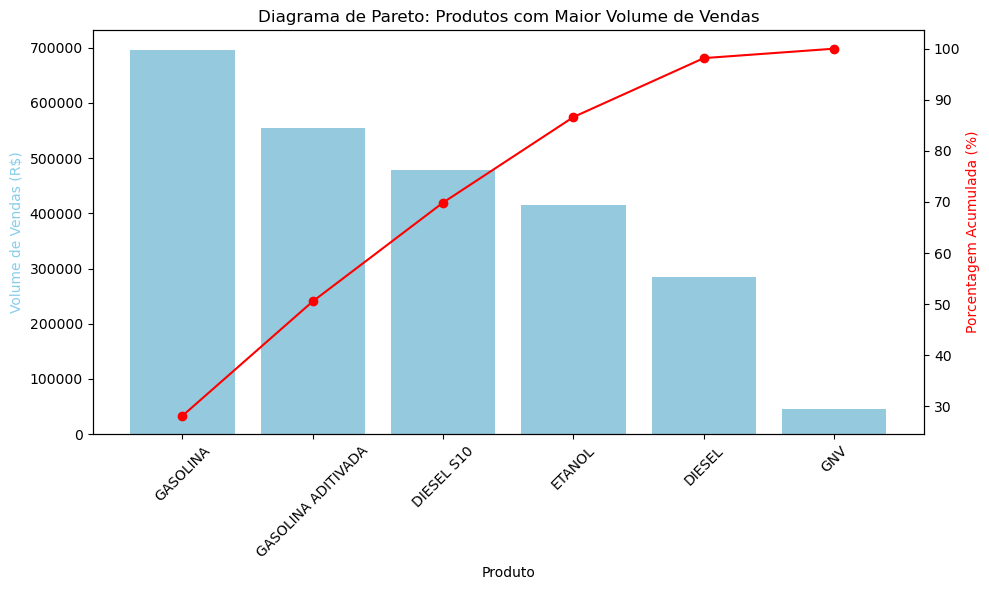

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando o total de vendas por produto
df_total_produto = df.groupby('Produto')['Valor de Venda'].sum().reset_index()

# Ordenando os produtos por volume de vendas
df_total_produto = df_total_produto.sort_values(by='Valor de Venda', ascending=False)

# Calculando a porcentagem acumulada
df_total_produto['Porcentagem Acumulada'] = df_total_produto['Valor de Venda'].cumsum() / df_total_produto['Valor de Venda'].sum() * 100

# Plotando o gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras
sns.barplot(data=df_total_produto, x='Produto', y='Valor de Venda', ax=ax1, color='skyblue')
ax1.set_ylabel('Volume de Vendas (R$)', color='skyblue')
ax1.set_xlabel('Produto')

# Definindo as posições dos ticks no eixo X
ticks_pos = df_total_produto['Produto'].unique()

# Definindo os rótulos dos ticks no eixo X
ax1.set_xticks(ticks_pos)
ax1.set_xticklabels(ticks_pos, rotation=45)

# Linha de porcentagem acumulada
ax2 = ax1.twinx()
ax2.plot(df_total_produto['Produto'], df_total_produto['Porcentagem Acumulada'], color='red', marker='o')
ax2.set_ylabel('Porcentagem Acumulada (%)', color='red')

plt.title('Diagrama de Pareto: Produtos com Maior Volume de Vendas')
plt.tight_layout()
plt.show()
